# Source Distributions


We will compare different source distributions for gridding potential field data
throught the Equivalent Layer method. Each source distributions is created as
a combination of a source layout and a depth type.
Lets define three layouts of point sources:

1. **Source below data**: One source point beneath each data point
2. **Block averaged sources**: Split the region in blocks of equal size, compute the
   averaged coordinate of the data points per block, and put one point source beneath
   this block-averaged coordinate.
3. **Grid of sources**: A regular grid of source points

And the depth types, i.e. how deep do we put the point sources:

1. **Constant depth**: Source points located all at the same depth, which can be
   computed as the minimum height of the data points minus a constant depth.
2. **Relative depth**: Each source is located at a constant distance beneath its
   corresponding observation (or block averaged) point.
3. **Variable depth**: Locate each source according to the Relative dpeth approach
   and then modify this depth by removing a term that depends on the averaged distance
   to the k nearest source points.

The first two layouts can be setted with any of these three types of depth, although
the grid of sources can only be defined with the constant depth.
Therefore we get a total of 7 possible combinations of layouts and depths:

|    | Constant depth | Relative depth | Variable depth |
| -- |----------------|----------------|----------------|
| **Source below data** | ✅ | ✅ | ✅ |
| **Block averaged sources** | ✅ | ✅ | ✅ |
| **Grid of sources** | ✅ | ❌ | ❌ |


Here we will show some examples on how each source distribution look like for the same
airborne survey.

**Import useful packages**

In [1]:
from IPython.display import display
from pathlib import Path
import pyproj
import numpy as np
import pandas as pd
import verde as vd
import matplotlib.pyplot as plt

import boost_and_layouts


## Define parameters for building the source distributions

In [2]:
# Define results directory to read synthetic ground survey
ground_results_dir = Path("..") / "results" / "ground_survey"
airborne_results_dir = Path("..") / "results" / "airborne_survey"

# Define dictionaries where the source distributions will be stored
layouts = ["source_below_data", "block_averaged_sources", "grid_sources"]
source_distributions = {layout: {} for layout in layouts}

# Define a region for the synthetic survey
region_degrees = [-0.5, 0.5, -0.5, 0.5]  # given in degrees

# Set a depth of 2km
depth = 2000

# Define a block size of 2km for block-averaged layouts
spacing = 4000

# Define set of parameters for each source distribution
# =====================================================
parameters = {layout: {} for layout in layouts}

# ... for source below data layout
layout = "source_below_data"
depth_type = "constant_depth"
parameters[layout][depth_type] = {
    "depth_type": depth_type,
    "depth": depth,
}
depth_type = "relative_depth"
parameters[layout][depth_type] = {
    "depth_type": depth_type,
    "depth": depth,
}
depth_type = "variable_depth"
parameters[layout][depth_type] = {
    "depth_type": depth_type,
    "depth_factor": 0.5,
    "depth": 500,
    "k_nearest": 15,
}

# ... for block-averaged sources layout
layout = "block_averaged_sources"
depth_type = "constant_depth"
parameters[layout][depth_type] = {
    "depth_type": depth_type,
    "spacing": spacing,
    "depth": depth,
}
depth_type = "relative_depth"
parameters[layout][depth_type] = {
    "depth_type": depth_type,
    "spacing": spacing,
    "depth": depth,
}
depth_type = "variable_depth"
parameters[layout][depth_type] = {
    "depth_type": depth_type,
    "depth_factor": 0.2,
    "depth": 500,
    "k_nearest": 2,
    "spacing": spacing,
}

layout = "grid_sources"
depth_type = "constant_depth"
parameters[layout][depth_type] = {
    "depth_type": depth_type,
    "spacing": spacing,
    "depth": depth,
}

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Read synthetic ground survey


Get coordinates of observation points from a synthetic ground survey

In [3]:
survey = pd.read_csv(ground_results_dir / "survey.csv")

Plot the survey points

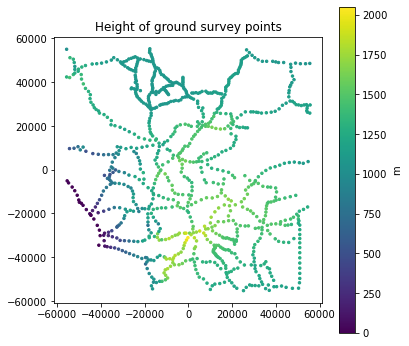

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=survey.height, s=6)
plt.colorbar(tmp, ax=ax, label="m")
ax.set_aspect("equal")
ax.set_title("Height of ground survey points")
plt.show()

Define coordinates tuple and the projected region

In [5]:
coordinates = (survey.easting, survey.northing, survey.height)
region = vd.get_region(coordinates)

### Generate the source distributions

In [6]:
for layout in parameters:
    for depth_type in parameters[layout]:
        source_distributions[layout][depth_type] = getattr(boost_and_layouts, layout)(
            coordinates, **parameters[layout][depth_type]
        )

Plot source distributions

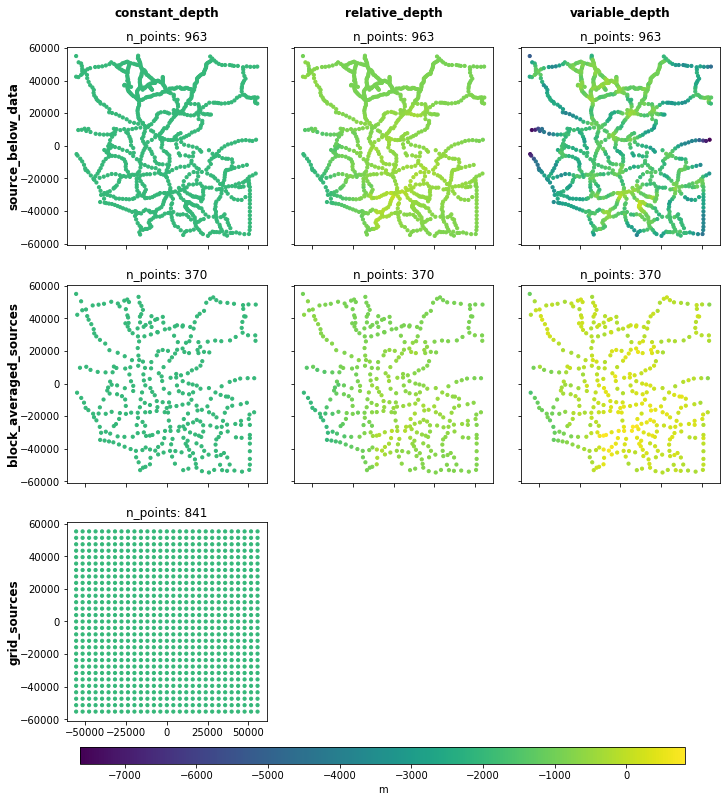

In [7]:
heights = tuple(
    source_distributions[layout][depth_type][2]
    for layout in source_distributions
    for depth_type in source_distributions[layout]
)
vmin = np.min([h.min() for h in heights])
vmax = np.max([h.max() for h in heights])

fig, axes = plt.subplots(figsize=(12, 12), nrows=3, ncols=3, sharex=True, sharey=True)
for i, (ax_row, layout) in enumerate(zip(axes, source_distributions)):
    for j, (ax, depth_type) in enumerate(zip(ax_row, source_distributions[layout])):
        points = source_distributions[layout][depth_type]
        tmp = ax.scatter(*points[:2], c=points[2], s=10, vmin=vmin, vmax=vmax)
        ax.set_title("n_points: {}".format(points[0].size))
        ax.set_aspect("equal")
        # Annotate the columns of the figure
        if i == 0:
            ax.text(
                0.5,
                1.15,
                depth_type,
                fontsize="large",
                fontweight="bold",
                horizontalalignment="center",
                transform=ax.transAxes,
            )
        # Annotate the rows of the figure
        if j == 0:
            ax.text(
                -0.3,
                0.5,
                layout,
                fontsize="large",
                fontweight="bold",
                verticalalignment="center",
                transform=ax.transAxes,
                rotation="vertical",
            )


# Hide the last two axes because they are not used
axes[-1][-1].set_visible(False)
axes[-1][-2].set_visible(False)

# Add colorbar
fig.subplots_adjust(bottom=0.1, wspace=0.05)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
fig.colorbar(tmp, cax=cbar_ax, orientation="horizontal", label="m")

plt.show()

## Read synthetic airborne survey


Get coordinates of observation points from a synthetic airborne survey

In [8]:
survey = pd.read_csv(airborne_results_dir / "survey.csv")

Project survey points into Cartesian coordinates

In [9]:
projection = pyproj.Proj(proj="merc", lat_ts=0)
survey["easting"], survey["northing"] = projection(
    survey.longitude.values, survey.latitude.values
)
display(survey)

# Define region boundaries in projected coordinates
region = (
    survey.easting.values.min(),
    survey.easting.values.max(),
    survey.northing.min(),
    survey.northing.max(),
)

,longitude,latitude,height,easting,northing,g_z
0,-0.496429,0.497339,633.0,-55262.223508,54993.627800,3.654625
1,-0.495559,0.497999,644.0,-55165.348426,55066.630053,2.503813
2,-0.493218,0.497479,646.0,-54904.787861,55009.113126,2.873545
3,-0.482725,0.497679,663.0,-53736.719343,55031.235020,3.125810
4,-0.478464,0.497719,672.0,-53262.365493,55035.659399,4.717045
...,...,...,...,...,...,...
5668,-0.416257,0.155824,1070.0,-46337.467390,17230.106636,10.041573
5669,-0.258422,0.271476,1087.0,-28767.445331,30018.377395,15.431621
5670,-0.258652,0.277958,1126.0,-28793.055985,30735.107734,14.078125
5671,-0.258983,0.287360,1106.0,-28829.801706,31774.809862,15.672714


Plot the survey points

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


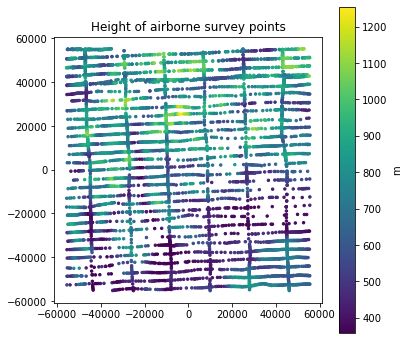

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=survey.height, s=6)
plt.colorbar(tmp, ax=ax, label="m")
ax.set_aspect("equal")
ax.set_title("Height of airborne survey points")
plt.show()

Define coordinates tuple and the projected region

In [11]:
coordinates = (survey.easting, survey.northing, survey.height)
region = vd.get_region(coordinates)

### Generate the source distributions

In [12]:
for layout in parameters:
    for depth_type in parameters[layout]:
        source_distributions[layout][depth_type] = getattr(boost_and_layouts, layout)(
            coordinates, **parameters[layout][depth_type]
        )

Plot source distributions

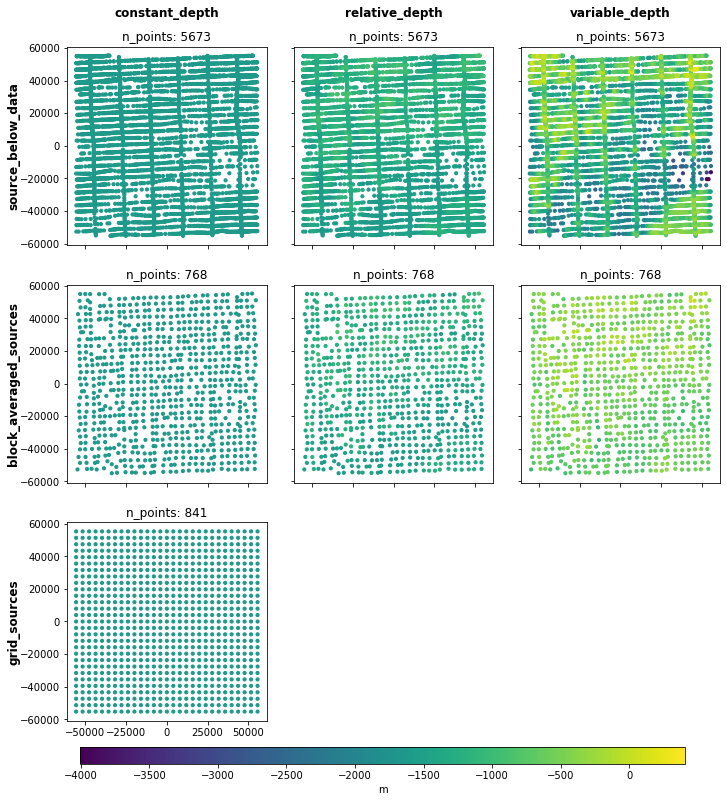

In [13]:
heights = tuple(
    source_distributions[layout][depth_type][2]
    for layout in source_distributions
    for depth_type in source_distributions[layout]
)
vmin = np.min([h.min() for h in heights])
vmax = np.max([h.max() for h in heights])

fig, axes = plt.subplots(figsize=(12, 12), nrows=3, ncols=3, sharex=True, sharey=True)
for i, (ax_row, layout) in enumerate(zip(axes, source_distributions)):
    for j, (ax, depth_type) in enumerate(zip(ax_row, source_distributions[layout])):
        points = source_distributions[layout][depth_type]
        tmp = ax.scatter(*points[:2], c=points[2], s=10, vmin=vmin, vmax=vmax)
        ax.set_title("n_points: {}".format(points[0].size))
        ax.set_aspect("equal")
        # Annotate the columns of the figure
        if i == 0:
            ax.text(
                0.5,
                1.15,
                depth_type,
                fontsize="large",
                fontweight="bold",
                horizontalalignment="center",
                transform=ax.transAxes,
            )
        # Annotate the rows of the figure
        if j == 0:
            ax.text(
                -0.3,
                0.5,
                layout,
                fontsize="large",
                fontweight="bold",
                verticalalignment="center",
                transform=ax.transAxes,
                rotation="vertical",
            )


# Hide the last two axes because they are not used
axes[-1][-1].set_visible(False)
axes[-1][-2].set_visible(False)

# Add colorbar
fig.subplots_adjust(bottom=0.1, wspace=0.05)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
fig.colorbar(tmp, cax=cbar_ax, orientation="horizontal", label="m")

plt.show()